In [1]:
import os
import pathlib

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)


In [2]:
import shutil
directory = 'sounds'
for filename in os.listdir(directory):
    if filename=='other' or filename=='stream':
        continue
    if 'stream' in filename:
        shutil.move(f"{directory}/{filename}", f"{directory}/stream/{filename.lstrip(' ').lstrip('-')}")
    else:
        shutil.move(f"{directory}/{filename}", f"{directory}/other/{filename.lstrip(' ').lstrip('-')}")

In [ ]:
df = pd.read_csv('database1.csv')
df.drop(columns='Unnamed: 0', inplace=True, errors='ignore')
df.head()

In [ ]:
for i in range(1,5):
    print(df[f'label{i}'].unique())

In [ ]:
def stream_encoder(x):
    return 1 if x=='stream' else 0

In [ ]:
for i in range(1,5):
    df[f'label{i}'] = df[f'label{i}'].apply(stream_encoder)

In [ ]:
df['stream'] = df[['label1', 'label2', 'label3', 'label4']].max(axis=1)
df.head()

In [ ]:
df.stream.sum()/len(df.stream)

In [3]:
data_dir = 'sounds'
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['other' 'stream']


In [11]:

filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(f'{data_dir}/{commands[0]}')))
print('Example file tensor:', filenames[0])

Number of total examples: 1084
Number of examples per label: 660
Example file tensor: tf.Tensor(b'sounds/other/waterfall-62.wav', shape=(), dtype=string)


In [12]:
train_files = filenames[:800]
val_files = filenames[800: 900]
test_files = filenames[900:]


print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 800
Validation set size 100
Test set size 184


In [13]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary, desired_channels=1)
  return tf.squeeze(audio, axis=-1)

In [14]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-2] 

In [15]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [16]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

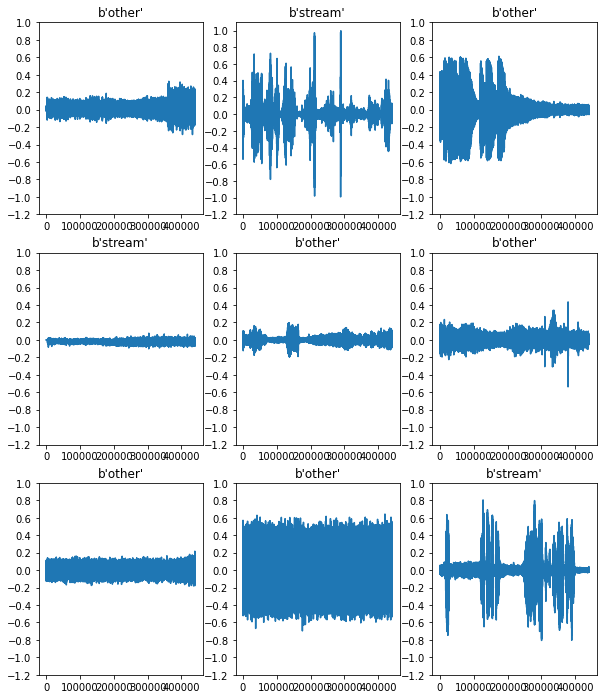

In [18]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy()[0:10*44100])
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy()
  ax.set_title(label)

plt.show()

In [19]:
def get_spectrogram(waveform):
  # Padding for files with less than 441000 samples
  #lower_bound = np.random.randint(waveform.get_shape()[0])
  #waveform = waveform[lower_bound: lower_bound+441000]
  zero_padding = tf.zeros([441000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
      
  spectrogram = tf.abs(spectrogram)

  return spectrogram

In [20]:
for waveform, label in waveform_ds.take(5):
  label = label.numpy()
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=44100))


Label: b'other'
Waveform shape: (441000,)
Spectrogram shape: (3444, 129)
Audio playback


In [21]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

<ipython-input-21-9d8460ca3c5a>:4: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)
<ipython-input-21-9d8460ca3c5a>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


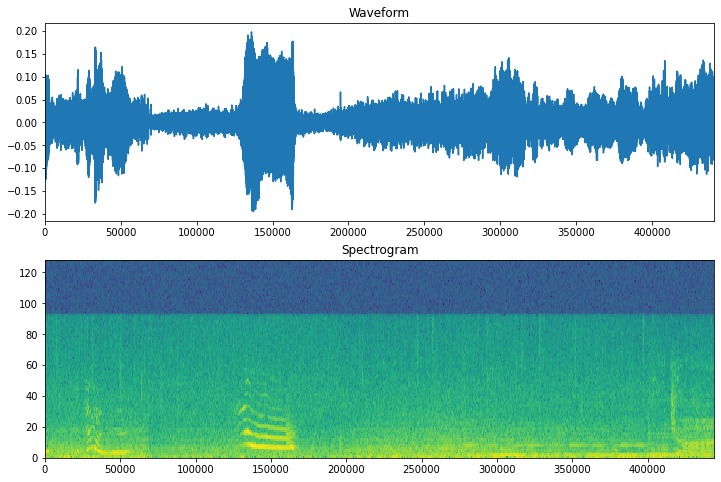

In [22]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, waveform.shape[0]])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [23]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [24]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)


<ipython-input-21-9d8460ca3c5a>:4: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)
<ipython-input-21-9d8460ca3c5a>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


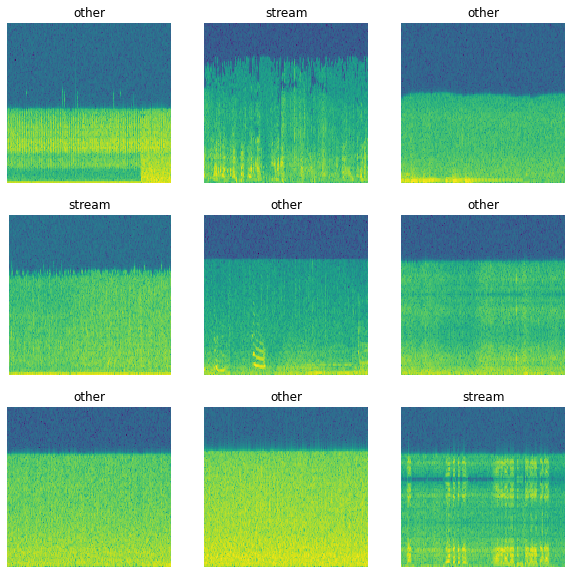

In [26]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()


In [27]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [28]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)


In [29]:
batch_size = 5
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [30]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [34]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

Input shape: (3444, 129, 1)


In [35]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [39]:
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
160/160 [==============================] - 2s 12ms/step - loss: 0.3423 - accuracy: 0.8338 - val_loss: 1.0680 - val_accuracy: 0.6200
Epoch 2/10
160/160 [==============================] - 2s 11ms/step - loss: 0.3292 - accuracy: 0.8438 - val_loss: 1.0595 - val_accuracy: 0.6000
Epoch 3/10
160/160 [==============================] - 2s 11ms/step - loss: 0.2526 - accuracy: 0.8775 - val_loss: 1.2987 - val_accuracy: 0.5700
Epoch 4/10
160/160 [==============================] - 2s 12ms/step - loss: 0.2377 - accuracy: 0.8888 - val_loss: 1.4075 - val_accuracy: 0.6200
Epoch 00004: early stopping


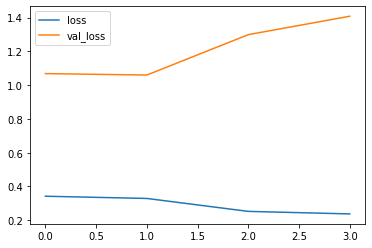

In [40]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [41]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [42]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 70%


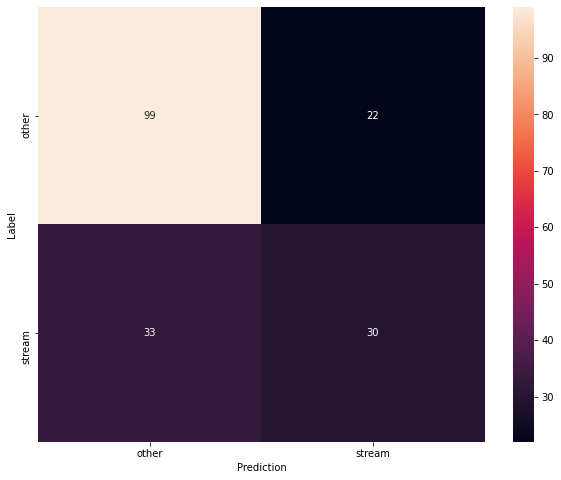

In [43]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [44]:
model.save('test_model')

INFO:tensorflow:Assets written to: test_model/assets
